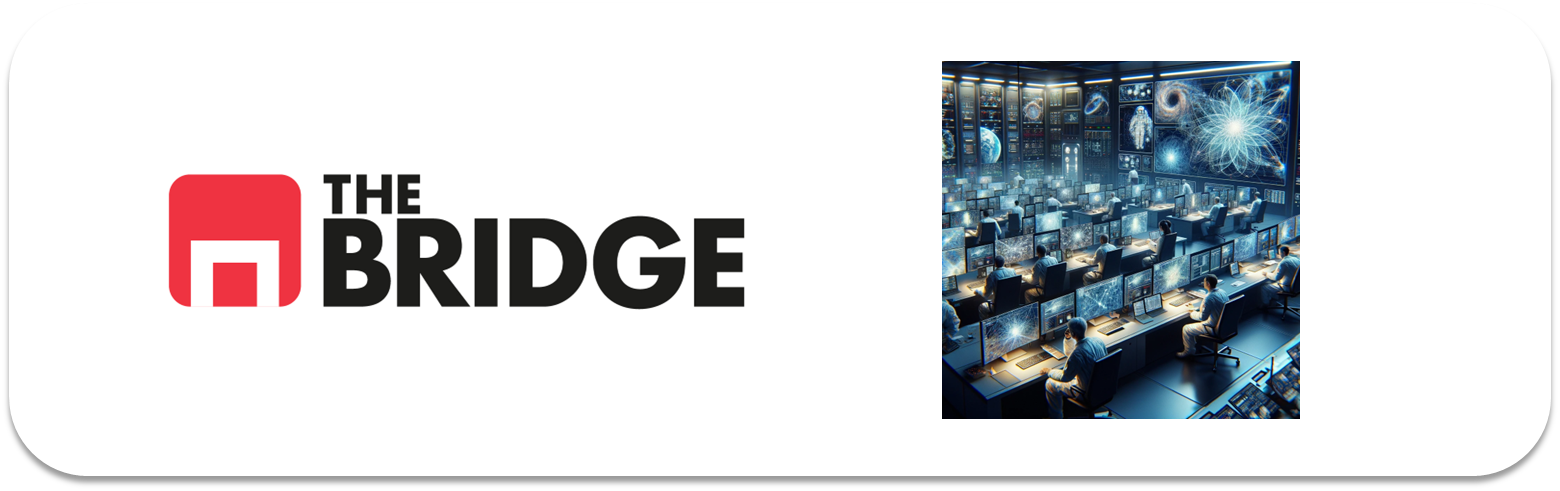

## PRACTICA OBLIGATORIA: **Transfer Learning y Fine Tuning**

* La práctica obligatoria de esta unidad consiste en un repetir el ejercicio de construcción de un modelo de clasificación de paisajes pero usando un modelo preentrenado. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

### Objetivo del ejercicio

Comparar una red convolucional hecha ad-hoc frente a los modelos preentrenados y ajustados con fine tuning y transfer learning. Para ello emplea el dataset de paisajes del conjunto de ejercicios de la unidad anterior.


### Se pide

1. Preparar los datos del modelo y las funciones de visualización, copia para ello todo lo que necesites de las soluciones del ejercicio de clasificación de paisajes de la unidad anterior.

2. Escoger entre uno de los modelos VGG-19, InceptionV3 y MobileNetV2 (todos en https://keras.io/api/applications/) (Se aconseja este último si no tenemos un ordenador muy potente). Si no te haces con estos puedes recurrir a la ResNetV50.

4. Hacer un transfer-learning con una cabeza de como mucho 2 capas densas ocultas y una de salida. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

5. Hacer un fine-tuning con la misma cabeza diseñada en el punto anterior. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

6. Comparar los resultados con los obtenidos con la red convolucional del ejercicio mencionado.

EXTRA:
- Repetir el transfer learning empleando aumentado de imágenes.



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.utils import shuffle
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from tensorflow.keras import Model
import pandas as pd
# ignore warnings
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from skimage.io import imread
from sklearn.utils import shuffle
import seaborn as sns
from sklearn.metrics import confusion_matrix
import keras
import cv2

In [3]:
ROOT_PATH = './data/'
TRAIN_PATH = ROOT_PATH + "seg_train/"
TEST_PATH = ROOT_PATH + "seg_test/"

In [4]:
def read_data(directorio, reshape_dim = (32,32)):
    X = [] 
    y = []
    for folder in os.listdir(directorio):
        print(folder)
        if os.path.isdir('/'.join([directorio, folder])):
            for file in os.listdir('/'.join([directorio, folder])):

                image = imread('/'.join([directorio, folder, file]))
                image = cv2.resize(image, reshape_dim) # Redimensionamos las imágenes a 32x32

                X.append(image)
                y.append(folder)

    return np.array(X),np.array(y)

In [6]:
X_train,y_train = read_data(TRAIN_PATH)
X_test, y_test = read_data(TEST_PATH) # Nota: podríamos dejar la creación de X_test para el final antes de usarlo y así ahorra memoria mientras no tengamos que emplearlo

buildings


forest
glacier
mountain
sea
street
buildings
forest
glacier
mountain
sea
street


In [7]:
print('X train shape: ', X_train.shape)
print('Y train shape: ', y_train.shape)

X train shape:  (14034, 32, 32, 3)
Y train shape:  (14034,)


In [8]:
print('X train shape: ', X_test.shape)
print('Y train shape: ', y_test.shape)

X train shape:  (3000, 32, 32, 3)
Y train shape:  (3000,)


In [9]:
def show_images_batch(paisajes, names = [], n_cols = 5, size_scale = 2):
    n_rows = ((len(paisajes) - 1) // n_cols + 1)
    plt.figure(figsize=(n_cols * size_scale, n_rows * 1.1*size_scale))
    for index, paisaje in enumerate(paisajes):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(paisaje, cmap = "Greys")
        plt.axis("off")
        if len(names):
            plt.title(names[index])

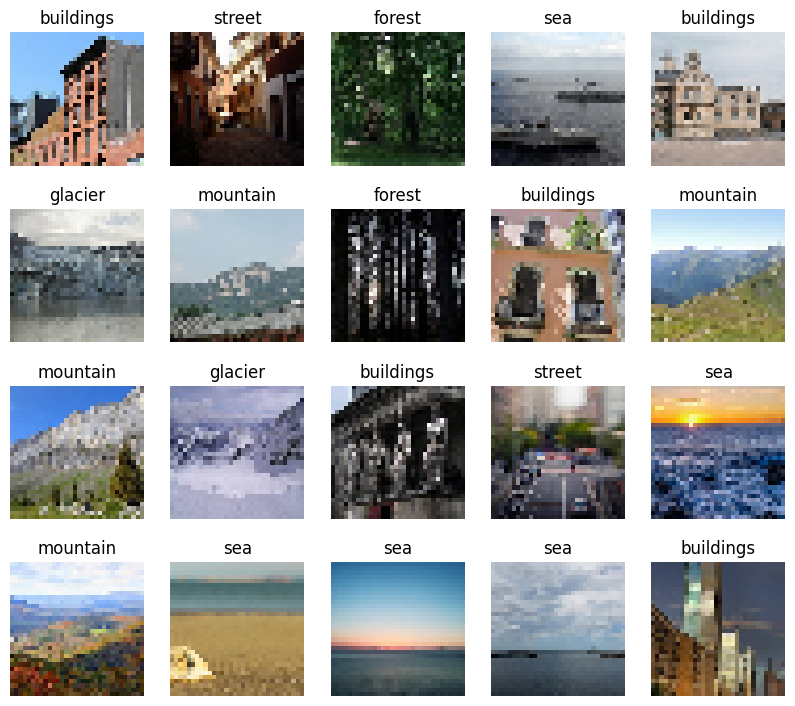

In [10]:
indices = np.random.randint(0,len(X_train),20)
show_images_batch(X_train[indices], names = y_train[indices], n_cols = 5)

In [11]:
targets = pd.Series(y_train)
targets.value_counts(True)

mountain     0.178994
glacier      0.171298
street       0.169731
sea          0.162035
forest       0.161821
buildings    0.156121
Name: proportion, dtype: float64

In [12]:
X_train = X_train/255
X_test = X_test/255

In [27]:
mapa = {tipo:indice for indice,tipo in enumerate(targets.unique())} # Rehusando la serie que creamos para ver la distribución del target
mapa

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [28]:
y_train_num = np.array([mapa[y] for y in y_train])
y_test_num = np.array([mapa[y] for y in y_test])

In [29]:
# Revolvemos los datos para que el modelo no aprenda en orden de las imágenes
X_train, y_train_num = shuffle(X_train, y_train_num)

In [30]:
keras.applications.MobileNetV2(
    input_shape=None,
    alpha=1.0,
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

In [31]:
# Cargamos el modelo pre-entrenado
base_model = keras.applications.MobileNetV2(include_top=False, weights='imagenet', input_shape=(32, 32, 3))

# Congelamos sus capas
for layer in base_model.layers:
    layer.trainable = False

# Capa de flatenizado de la salida del modelo base
def prepare_model(base_model = base_model): # Lo creamos así para poder reinicializarlo en cada reentrenamiento en ejercicios posteriores
    x = layers.Flatten()(base_model.output)
    
    # Capa densa con 300 neuronas
    x = layers.Dense(300, activation='relu')(x)
    x = layers.Dropout(rate = 0.5)(x)

    
    # Capa final de salida con 13 neuronas y activación softmax
    x = layers.Dense(13, activation='softmax')(x)
    
    model = Model(base_model.input, x)
    model.compile(optimizer = "adam", loss = 'sparse_categorical_crossentropy', metrics = ['acc'])
    return model
# Observamos la arquitectura del modelo
model= prepare_model()
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 16, 16, 32)           864       ['input_6[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 16, 16, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 16, 16, 32)           0         ['bn_Conv1[0][0]']      

In [32]:
earlyS = EarlyStopping(patience= 5, restore_best_weights= True)

In [21]:
X_train.shape

(14034, 32, 32, 3)

In [22]:
instancias_train = len(X_train)
for i in range(1,5):
    print(f"Batch_size: {32*i}, num_steps_per_epoch: {round(instancias_train/(32*i))}")

Batch_size: 32, num_steps_per_epoch: 439
Batch_size: 64, num_steps_per_epoch: 219
Batch_size: 96, num_steps_per_epoch: 146
Batch_size: 128, num_steps_per_epoch: 110


In [35]:
batch_size = 64

In [38]:
# Entrenamos el modelo
from time import time
t_zero = time()
model = prepare_model()
history = model.fit(X_train, 
                    y_train_num,
                    batch_size = batch_size,
                    validation_split=0.2,
                    epochs=5,)
print(time() - t_zero)

Epoch 1/5
176/176 [==============================] - 19s 69ms/step - loss: 1.5874 - acc: 0.4227 - val_loss: 1.3017 - val_acc: 0.4820
Epoch 2/5
176/176 [==============================] - 10s 55ms/step - loss: 1.2733 - acc: 0.4926 - val_loss: 1.2577 - val_acc: 0.5037
Epoch 3/5
176/176 [==============================] - 10s 55ms/step - loss: 1.2385 - acc: 0.5083 - val_loss: 1.2381 - val_acc: 0.5098
Epoch 4/5
176/176 [==============================] - 10s 55ms/step - loss: 1.2127 - acc: 0.5181 - val_loss: 1.2223 - val_acc: 0.5187
Epoch 5/5
176/176 [==============================] - 10s 55ms/step - loss: 1.1966 - acc: 0.5297 - val_loss: 1.2154 - val_acc: 0.5180
58.35571336746216


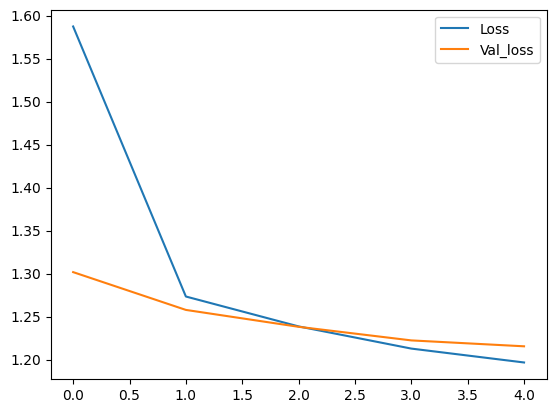

In [40]:
plt.plot(history_df['loss'], label = 'Loss')
plt.plot(history_df['val_loss'], label = 'Val_loss')

plt.legend();

In [41]:
model.evaluate(X_test, y_test_num)

94/94 [==============================] - 3s 36ms/step - loss: 1.2178 - acc: 0.5180


[1.2178272008895874, 0.5180000066757202]

In [42]:
y_pred = [ np.argmax(prediction) for prediction in model.predict(X_test)]

94/94 [==============================] - 5s 35ms/step


In [43]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
inverse_map = {valor:clave for clave,valor in mapa.items()}
y_test_labels = [inverse_map[y] for y in y_test_num]
y_pred_labels = [inverse_map[y] for y in y_pred]
print(classification_report(y_test_labels, y_pred_labels))

              precision    recall  f1-score   support

   buildings       0.50      0.50      0.50       437
      forest       0.73      0.83      0.77       474
     glacier       0.48      0.33      0.39       553
    mountain       0.47      0.51      0.49       525
         sea       0.46      0.50      0.48       510
      street       0.45      0.47      0.46       501

    accuracy                           0.52      3000
   macro avg       0.52      0.52      0.52      3000
weighted avg       0.51      0.52      0.51      3000



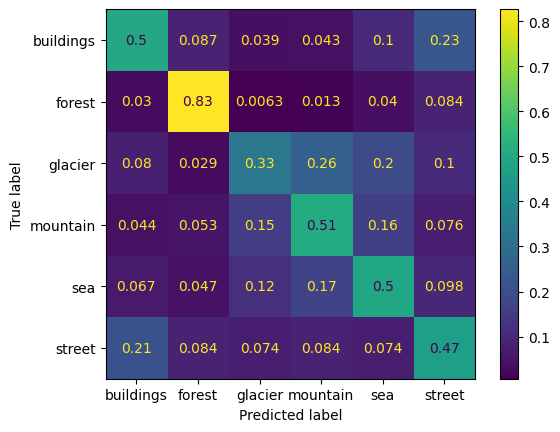

In [44]:
ConfusionMatrixDisplay.from_predictions(y_test_labels, y_pred_labels, normalize="true")


In [48]:
confianza = [prediction.max() for prediction in model.predict(X_test)]

94/94 [==============================] - 4s 45ms/step


In [49]:
pred_df = pd.DataFrame({"True": y_test_labels, "Predicted": y_pred_labels, "Confianza": confianza})

In [50]:
error = pred_df["True"] != pred_df["Predicted"]
errores = pred_df[error].sort_values("Confianza", ascending = False)
errores

,True,Predicted,Confianza
1680,mountain,forest,0.997141
2111,sea,forest,0.991871
1893,mountain,forest,0.979862
2208,sea,forest,0.965236
226,buildings,forest,0.960452
...,...,...,...
1053,glacier,street,0.219420
2589,street,buildings,0.215924
2653,street,mountain,0.214591
2955,street,forest,0.213448


In [51]:
for true_label, predicted_label in errores.iloc[0:10,0:2].values:
    print(true_label, predicted_label)

mountain forest
sea forest
mountain forest
sea forest
buildings forest
sea buildings
buildings forest
mountain forest
glacier forest
buildings forest


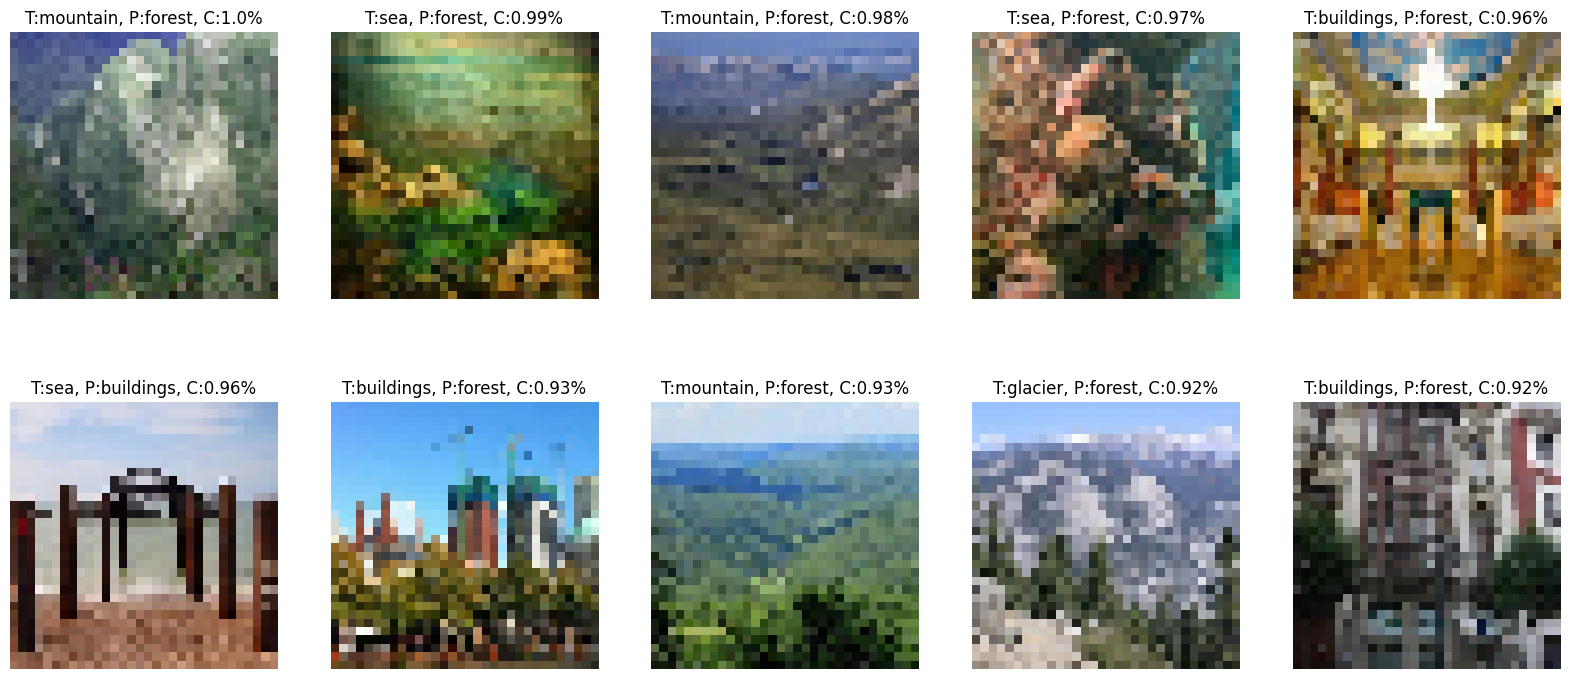

In [52]:
show_images_batch(X_test[errores.iloc[0:10].index],names= [f"T:{val1}, P:{val2}, C:{round(val3,2)}%" for val1,val2,val3 in errores.iloc[0:10].values], size_scale= 4)

In [53]:
# Cargamos el modelo pre-entrenado
base_model = keras.applications.MobileNetV2(include_top=False, weights=None, input_shape=(32, 32, 3))

# Capa de flatenizado de la salida del modelo base
def prepare_model(base_model = base_model): # Lo creamos así para poder reinicializarlo en cada reentrenamiento en ejercicios posteriores
    x = layers.Flatten()(base_model.output)
    
    # Capa densa con 300 neuronas
    x = layers.Dense(300, activation='relu')(x)
    x = layers.Dropout(rate = 0.5)(x)

    
    # Capa final de salida con 13 neuronas y activación softmax
    x = layers.Dense(13, activation='softmax')(x)
    
    model = Model(base_model.input, x)
    model.compile(optimizer = "adam", loss = 'sparse_categorical_crossentropy', metrics = ['acc'])
    return model
# Observamos la arquitectura del modelo
model= prepare_model()
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 16, 16, 32)           864       ['input_7[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 16, 16, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 16, 16, 32)           0         ['bn_Conv1[0][0]']      

In [54]:
earlySFT = EarlyStopping(restore_best_weights= True, patience= 10)